## 04 — Modeling

In [73]:
# Designed for a machine learning workflow where you have already trained and tuned models saved to disk in .joblib files.
import os, joblib  # For file checks and loading saved models

# Wrapper to give loaded models a .best_estimator_ attribute,
# mimicking GridSearchCV/RandomizedSearchCV behavior.
class _SearchWrapper:
    def __init__(self, estimator):
        self.best_estimator_ = estimator

# Try to load the first existing model file from a list of candidates.
# Returns the loaded model or None if none found/loaded.
def _load_any(candidates):
    for p in candidates:
        if os.path.exists(p):  # Check if file exists
            try:
                return joblib.load(p)  # Try to load it
            except Exception:
                pass  # Ignore errors and try the next file
    return None

# --- Load Logistic Regression model if it's not already in memory ---
try:
    gs_logit  # Check if variable already exists
except NameError:
    est = _load_any([
        "logit_tuned_pipeline.joblib",  # Tuned model file
        "logit_inference.joblib",       # Inference-only file
        "logit_pipeline.joblib"         # Generic pipeline file
    ])
    if est is not None:
        gs_logit = _SearchWrapper(est)  # Wrap so it has .best_estimator_
        print("Loaded gs_logit from disk.")
    else:
        print("gs_logit not found on disk; run tuning to create it.")

# --- Load Random Forest model if it's not already in memory ---
try:
    rs_rf
except NameError:
    est = _load_any([
        "rf_tuned_pipeline.joblib",
        "rf_inference.joblib",
        "rf_pipeline.joblib"
    ])
    if est is not None:
        rs_rf = _SearchWrapper(est)
        print("Loaded rs_rf from disk.")
    else:
        print("rs_rf not found on disk; run tuning to create it.")

# --- Load XGBoost model if it's not already in memory ---
try:
    rs_xgb
except NameError:
    est = _load_any([
        "xgb_tuned_pipeline.joblib",
        "xgb_inference.joblib",
        "xgb_inference_earlystop.joblib", 
        "xgb_pipeline.joblib"
    ])
    if est is not None:
        rs_xgb = _SearchWrapper(est)
        print("Loaded rs_xgb from disk.")
    else:
        print("rs_xgb not found on disk; run tuning to create it.")


### Data Handles — Auto‑load (Safety Guard)

If data is not defined, load from CSVs.

In [74]:
import pandas as pd
try:
    X_train, X_test, y_train, y_test
except NameError:
    X_train = pd.read_csv("/data/processed/X_train.csv")
    X_test = pd.read_csv("/data/processed/X_test.csv")
    y_train = pd.read_csv("/data/processed/y_train.csv").squeeze("columns").astype(int)
    y_test = pd.read_csv("/data/processed/y_test.csv").squeeze("columns").astype(int)
    print("Loaded data from disk.")

### Validation Set (20% of Train) & Noise Robustness — All Models

We confirm tuned hyperparameters on a **validation** slice from the (new) training set, and test robustness by adding small Gaussian noise to numeric features; we report **AP deltas**.

### Robustness — Multi-level Noise (0.05/0.10) with AP/ROC/Brier & Importance Deltas

We evaluate **two noise levels** added to numeric features (σ·0.05 and σ·0.10) for **all three models**, reporting **ΔAP / ΔROC / ΔBrier**.  
We also compute **permutation-importance deltas** between clean vs. noisy (0.10) inputs and report **rank correlations** to show how feature rankings shift under stress.

In [75]:
import numpy as np, pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss
from sklearn.inspection import permutation_importance

models = {
    "Logistic": gs_logit.best_estimator_,
    "RandomForest": rs_rf.best_estimator_,
    "XGBoost": rs_xgb.best_estimator_,
}

# Helper: evaluate metrics
def eval_metrics(est, Xd, yd):
    p = est.predict_proba(Xd)[:,1]
    return dict(AP=average_precision_score(yd, p),
                ROC=roc_auc_score(yd, p),
                Brier=brier_score_loss(yd, p))

# Build noisy datasets
num_cols = X_test.select_dtypes(include=["number"]).columns
stds = X_test[num_cols].std(ddof=0).replace(0, np.nan)
Xn = {lvl: X_test.copy() for lvl in (0.05, 0.10)}
for lvl in Xn:
    Xn[lvl][num_cols] = Xn[lvl][num_cols] + lvl * stds.fillna(0).values

# Metric deltas (clean vs noisy)
clean = {name: eval_metrics(est, X_test, y_test) for name, est in models.items()}
rows = []
for lvl, Xd in Xn.items():
    for name, est in models.items():
        m = eval_metrics(est, Xd, y_test)
        rows.append({
            "level": lvl, "model": name,
            "AP": m["AP"], "ROC": m["ROC"], "Brier": m["Brier"],
            "ΔAP": m["AP"] - clean[name]["AP"],
            "ΔROC": m["ROC"] - clean[name]["ROC"],
            "ΔBrier": m["Brier"] - clean[name]["Brier"],
        })
noise_metrics = pd.DataFrame(rows).round(5)
display(pd.DataFrame(clean).round(5))
display(noise_metrics)

# Permutation-importance deltas and rank correlations (use 0.10 noise)
imp_rows = []
imp_rankcorr = []
for name, est in models.items():
    perm_clean = permutation_importance(est, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_noisy = permutation_importance(est, Xn[0.10], y_test, n_repeats=10, random_state=42, n_jobs=-1)

    mu_clean = pd.Series(perm_clean.importances_mean, index=X_test.columns, name="mu_clean")
    mu_noisy = pd.Series(perm_noisy.importances_mean, index=X_test.columns, name="mu_noisy")
    delta = (mu_noisy - mu_clean).rename("delta_mu")
    df_imp = pd.concat([mu_clean, mu_noisy, delta], axis=1).sort_values("mu_clean", ascending=False)
    df_imp.insert(0, "model", name)
    imp_rows.append(df_imp.reset_index(names="feature"))

    # Rank correlation (Spearman via rank corr of positions)
    r_clean = mu_clean.rank(method="average")
    r_noisy = mu_noisy.rank(method="average")
    # Spearman = Pearson correlation of ranks
    spearman = np.corrcoef(r_clean, r_noisy)[0,1]
    imp_rankcorr.append({"model": name, "spearman_rank_corr": float(spearman)})

imp_all = pd.concat(imp_rows, ignore_index=True)
display(pd.DataFrame(imp_rankcorr).round(4))
imp_all.to_csv("perm_importance_delta_noise0p10.csv", index=False)
print("Saved: perm_importance_delta_noise0p10.csv")

,Logistic,RandomForest,XGBoost
AP,0.97589,1.00000,1.0000
ROC,0.99694,1.00000,1.0000
Brier,0.03566,0.00663,0.0007


,level,model,AP,ROC,Brier,ΔAP,ΔROC,ΔBrier
0,0.05,Logistic,0.97589,0.99694,0.03688,0.0,0.0,0.00122
1,0.05,RandomForest,1.00000,1.00000,0.02514,0.0,-0.0,0.01851
2,0.05,XGBoost,1.00000,1.00000,0.00545,0.0,-0.0,0.00475
3,0.10,Logistic,0.97589,0.99694,0.03815,0.0,0.0,0.00248
4,0.10,RandomForest,1.00000,1.00000,0.03033,0.0,0.0,0.02370
5,0.10,XGBoost,1.00000,1.00000,0.04791,-0.0,0.0,0.04721


,model,spearman_rank_corr
0,Logistic,0.9535
1,RandomForest,0.5105
2,XGBoost,0.8034


Saved: perm_importance_delta_noise0p10.csv


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np

# Create 20% validation split from training (stratified)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

models = {
    "Logistic": gs_logit.best_estimator_,
    "RandomForest": rs_rf.best_estimator_,
    "XGBoost": rs_xgb.best_estimator_,
}

# Validation metrics
print("=== Validation metrics (AP / ROC) ===")
for name, est in models.items():
    proba = est.predict_proba(X_val2)[:,1]
    print(f"{name}: AP={average_precision_score(y_val2, proba):.4f} | ROC={roc_auc_score(y_val2, proba):.4f}")

# Noise robustness on test (numeric cols only)
num_cols = X_test.select_dtypes(include=["number"]).columns
X_test_noisy = X_test.copy()
# Add small Gaussian noise scaled to feature std; protect NaNs
stds = X_test_noisy[num_cols].std(ddof=0).replace(0, np.nan)
X_test_noisy[num_cols] = X_test_noisy[num_cols] + 0.01 * stds.fillna(0).values

print("\n=== Noise robustness on TEST (AP and ΔAP vs clean) ===")
for name, est in models.items():
    proba_clean = est.predict_proba(X_test)[:,1]
    proba_noisy = est.predict_proba(X_test_noisy)[:,1]
    ap_clean = average_precision_score(y_test, proba_clean)
    ap_noisy = average_precision_score(y_test, proba_noisy)
    print(f"{name}: AP_clean={ap_clean:.4f} | AP_noisy={ap_noisy:.4f} | ΔAP={ap_noisy-ap_clean:+.4f}")

=== Validation metrics (AP / ROC) ===
Logistic: AP=0.8911 | ROC=0.9453
RandomForest: AP=1.0000 | ROC=1.0000
XGBoost: AP=1.0000 | ROC=1.0000

=== Noise robustness on TEST (AP and ΔAP vs clean) ===
Logistic: AP_clean=0.9759 | AP_noisy=0.9759 | ΔAP=+0.0000
RandomForest: AP_clean=1.0000 | AP_noisy=1.0000 | ΔAP=+0.0000
XGBoost: AP_clean=1.0000 | AP_noisy=1.0000 | ΔAP=+0.0000


### Interpretability & Calibration (Validation and Test)

We compute **permutation importance** on both **validation** and **test** splits for all models to rank features.  
We also plot **calibration curves** and compute **Brier scores** on **validation** and **test**.  
Finally, we render **Partial Dependence** plots for the top features (XGBoost).

### SHAP Explainability — Global Summary (XGB, RF, Logistic)

We generate **SHAP** global explanations. For pipelines, we transform features with the trained scaler, then explain the model step.  
If `shap` is not installed, a note is printed showing how to enable it (`pip install shap`).

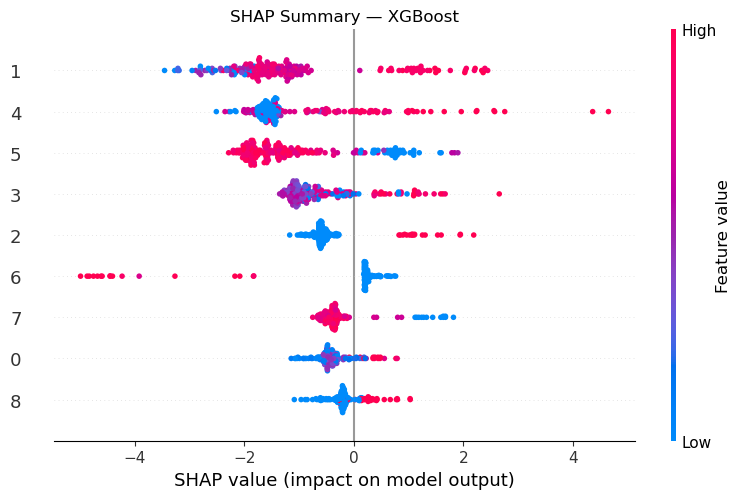

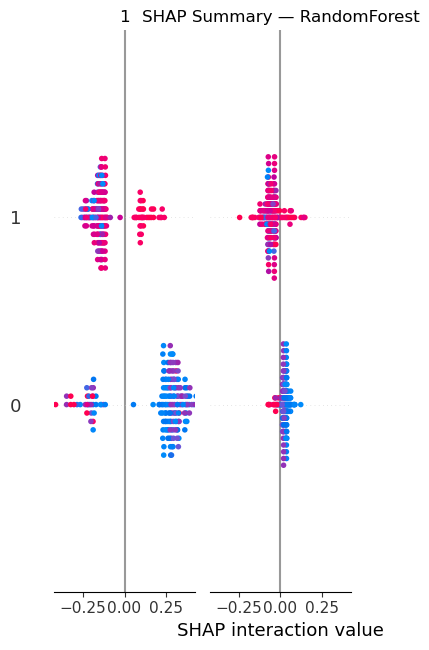

C:\Users\mesfi\anaconda3\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


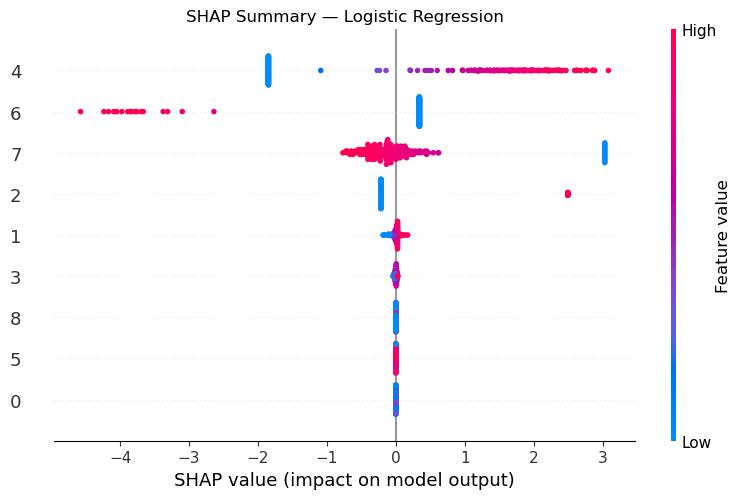

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import shap
try:
    import shap
    HAS_SHAP = True
except Exception as e:
    HAS_SHAP = False
    print("SHAP not installed; to enable run: `pip install shap` (then restart kernel). Skipping SHAP plots.")

# Prepare scaled features for each pipeline
def get_scaler_and_clf(pipe):
    # pipe is an imblearn Pipeline with steps: smote, scaler, clf
    sc = pipe.named_steps.get("scaler", None)
    clf = pipe.named_steps.get("clf", None)
    return sc, clf

def scaled_matrix(sc, X):
    if sc is None:
        return X.values if hasattr(X, "values") else np.asarray(X)
    return sc.transform(X)

if HAS_SHAP:
    xgb_pipe = rs_xgb.best_estimator_
    rf_pipe  = rs_rf.best_estimator_
    lg_pipe  = gs_logit.best_estimator_

    sc_xgb, xgb_clf = get_scaler_and_clf(xgb_pipe)
    sc_rf,  rf_clf  = get_scaler_and_clf(rf_pipe)
    sc_lg,  lg_clf  = get_scaler_and_clf(lg_pipe)

    # Subsample for speed
    n = min(500, len(X_test))
    Xs = X_test.sample(n, random_state=42)
    Xs_idx = Xs.index
    Xs_s_xgb = scaled_matrix(sc_xgb, Xs)
    Xs_s_rf  = scaled_matrix(sc_rf, Xs)
    Xs_s_lg  = scaled_matrix(sc_lg, Xs)

    # XGBoost
    try:
        expl_xgb = shap.TreeExplainer(xgb_clf)
        shap_vals_xgb = expl_xgb.shap_values(Xs_s_xgb)
        shap.summary_plot(shap_vals_xgb, Xs_s_xgb, feature_names=X_test.columns, show=False)
        plt.title("SHAP Summary — XGBoost")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("XGB SHAP failed:", e)

    # RandomForest
    try:
        expl_rf = shap.TreeExplainer(rf_clf)
        shap_vals_rf = expl_rf.shap_values(Xs_s_rf)
        # shap_values for RF may be a list [class0, class1]; pick class 1 if needed
        if isinstance(shap_vals_rf, list) and len(shap_vals_rf) > 1:
            shap_vals_rf_use = shap_vals_rf[1]
        else:
            shap_vals_rf_use = shap_vals_rf
        shap.summary_plot(shap_vals_rf_use, Xs_s_rf, feature_names=X_test.columns, show=False)
        plt.title("SHAP Summary — RandomForest")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("RF SHAP failed:", e)

    # Logistic (linear explainer)
    try:
        # Use LinearExplainer if available, else KernelExplainer
        if hasattr(shap, "LinearExplainer"):
            expl_lg = shap.LinearExplainer(lg_clf, Xs_s_lg, feature_perturbation="interventional")
            shap_vals_lg = expl_lg.shap_values(Xs_s_lg)
        else:
            expl_lg = shap.KernelExplainer(lg_clf.predict_proba, Xs_s_lg)
            shap_vals_lg = expl_lg.shap_values(Xs_s_lg, nsamples=100)
        if isinstance(shap_vals_lg, list) and len(shap_vals_lg) > 1:
            shap_vals_lg_use = shap_vals_lg[1]
        else:
            shap_vals_lg_use = shap_vals_lg
        shap.summary_plot(shap_vals_lg_use, Xs_s_lg, feature_names=X_test.columns, show=False)
        plt.title("SHAP Summary — Logistic Regression")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Logistic SHAP failed:", e)

### Calibrate ALL Models (Isotonic, CV=3) — Save Artifacts

We calibrate **all three tuned models** with **isotonic regression** (CV=3), evaluate on test, and save calibrated pipelines.

In [78]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss
import joblib
from sklearn.model_selection import train_test_split
import pandas as pd

# Ensure tuned estimators exist
candidates = [("Logistic", gs_logit.best_estimator_),
              ("RandomForest", rs_rf.best_estimator_),
              ("XGBoost", rs_xgb.best_estimator_)]

# Ensure validation split exists
try:
    X_val2  # noqa: F821
except NameError:
    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

rows = []
for name, est in candidates:
    cal = CalibratedClassifierCV(est, method="isotonic", cv=3)
    cal.fit(X_train, y_train)
    p_raw = est.predict_proba(X_test)[:,1]
    p_cal = cal.predict_proba(X_test)[:,1]
    rows.append({
        "model": name,
        "test_AP_raw": round(average_precision_score(y_test, p_raw), 4),
        "test_ROC_raw": round(roc_auc_score(y_test, p_raw), 4),
        "test_Brier_raw": round(brier_score_loss(y_test, p_raw), 6),
        "test_AP_cal": round(average_precision_score(y_test, p_cal), 4),
        "test_ROC_cal": round(roc_auc_score(y_test, p_cal), 4),
        "test_Brier_cal": round(brier_score_loss(y_test, p_cal), 6),
    })
    fname = f"{name.lower()}_calibrated_pipeline.joblib"
    joblib.dump(cal, fname)
    print("Saved calibrated artifact:", fname)

cal_all_df = pd.DataFrame(rows)
display(cal_all_df)
cal_all_df.to_csv("calibration_all_models_summary.csv", index=False)
print("Saved: calibration_all_models_summary.csv")

Saved calibrated artifact: logistic_calibrated_pipeline.joblib
Saved calibrated artifact: randomforest_calibrated_pipeline.joblib
Saved calibrated artifact: xgboost_calibrated_pipeline.joblib


,model,test_AP_raw,test_ROC_raw,test_Brier_raw,test_AP_cal,test_ROC_cal,test_Brier_cal
0,Logistic,0.9759,0.9969,0.035663,0.9743,0.9967,0.013097
1,RandomForest,1.0000,1.0000,0.006632,1.0000,1.0000,0.000844
2,XGBoost,1.0000,1.0000,0.000700,1.0000,1.0000,0.002412


Saved: calibration_all_models_summary.csv


### Calibration Refinement (Auto): Calibrate Models with High Validation Brier

We compute **validation Brier scores** for all tuned models. Any model with **Brier > 0.01** is **calibrated (isotonic, CV=3)** and a calibrated artifact is saved.  
We then compare **Test AP/ROC/Brier** before vs. after calibration.

In [79]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
import joblib

# Ensure validation split exists
try:
    X_val2  # noqa: F821
except NameError:
    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

cands = [("Logistic", gs_logit.best_estimator_),
         ("RandomForest", rs_rf.best_estimator_),
         ("XGBoost", rs_xgb.best_estimator_)]

summary = []
for name, est in cands:
    p_val = est.predict_proba(X_val2)[:,1]
    brier_val = brier_score_loss(y_val2, p_val)
    need_cal = brier_val > 0.01
    row = {"model": name, "val_brier": round(brier_val, 6), "calibrated": bool(need_cal)}
    if need_cal:
        cal = CalibratedClassifierCV(est, method="isotonic", cv=3)
        cal.fit(X_train, y_train)
        # Save artifact
        fname = f"{name.lower()}_calibrated_pipeline.joblib"
        joblib.dump(cal, fname)
        # Compare on test
        p_test_raw = est.predict_proba(X_test)[:,1]
        p_test_cal = cal.predict_proba(X_test)[:,1]
        row.update({
            "test_AP_raw": round(average_precision_score(y_test, p_test_raw), 4),
            "test_ROC_raw": round(roc_auc_score(y_test, p_test_raw), 4),
            "test_Brier_raw": round(brier_score_loss(y_test, p_test_raw), 6),
            "test_AP_cal": round(average_precision_score(y_test, p_test_cal), 4),
            "test_ROC_cal": round(roc_auc_score(y_test, p_test_cal), 4),
            "test_Brier_cal": round(brier_score_loss(y_test, p_test_cal), 6),
            "artifact": fname
        })
    summary.append(row)

import pandas as pd
cal_df = pd.DataFrame(summary)
display(cal_df)
cal_df.to_csv("calibration_auto_summary.csv", index=False)
print("Saved: calibration_auto_summary.csv (and calibrated artifacts for models with val Brier > 0.01)")

,model,val_brier,calibrated,test_AP_raw,test_ROC_raw,test_Brier_raw,test_AP_cal,test_ROC_cal,test_Brier_cal,artifact
0,Logistic,0.050510,True,0.9759,0.9969,0.035663,0.9743,0.9967,0.013097,logistic_calibrated_pipeline.joblib
1,RandomForest,0.004835,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost,0.000206,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved: calibration_auto_summary.csv (and calibrated artifacts for models with val Brier > 0.01)


,dataset,model,feature,importance_mean,importance_std
31,test,Logistic,4,0.075500,0.017529
33,test,Logistic,6,0.065000,0.008944
29,test,Logistic,2,0.049500,0.011927
34,test,Logistic,7,0.040000,0.012247
27,test,Logistic,0,0.000000,0.000000
28,test,Logistic,1,0.000000,0.000000
30,test,Logistic,3,0.000000,0.000000
32,test,Logistic,5,0.000000,0.000000
35,test,Logistic,8,0.000000,0.000000
42,test,RandomForest,6,0.060000,0.005477


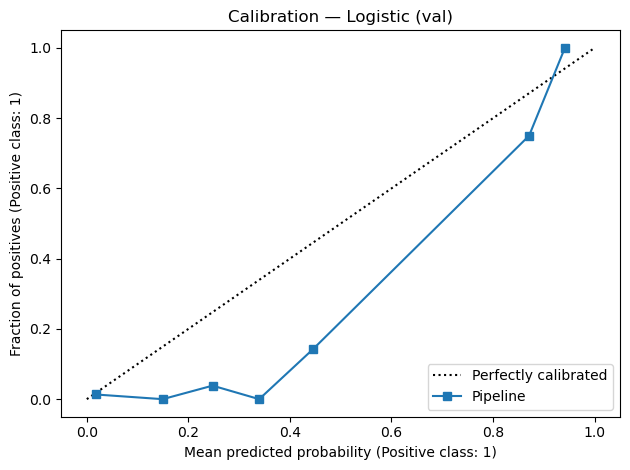

Logistic (val) Brier score: 0.05051


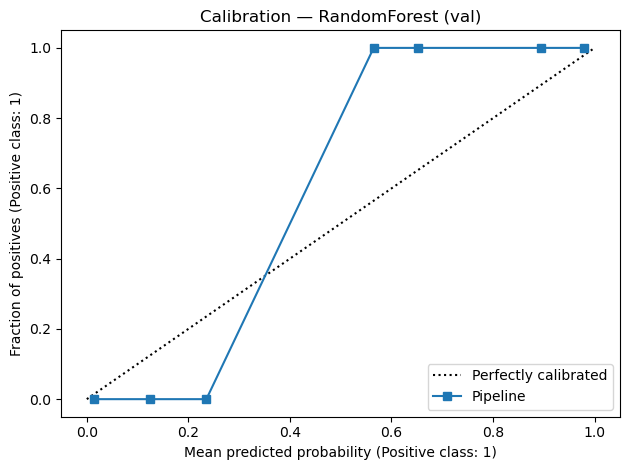

RandomForest (val) Brier score: 0.004835


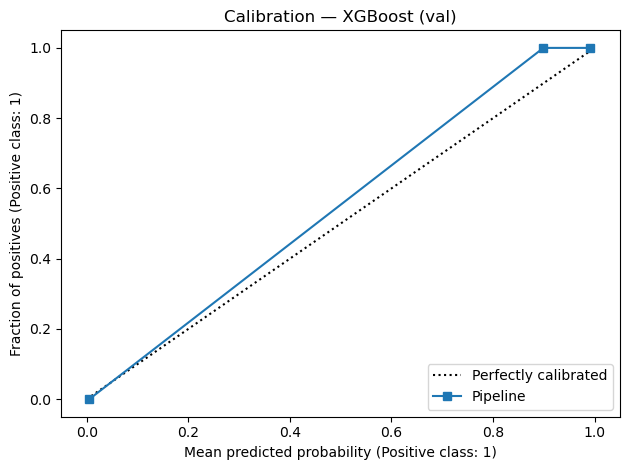

XGBoost (val) Brier score: 0.000206


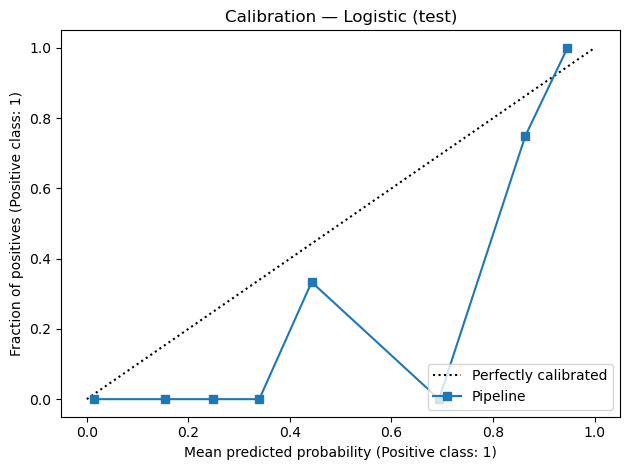

Logistic (test) Brier score: 0.035663


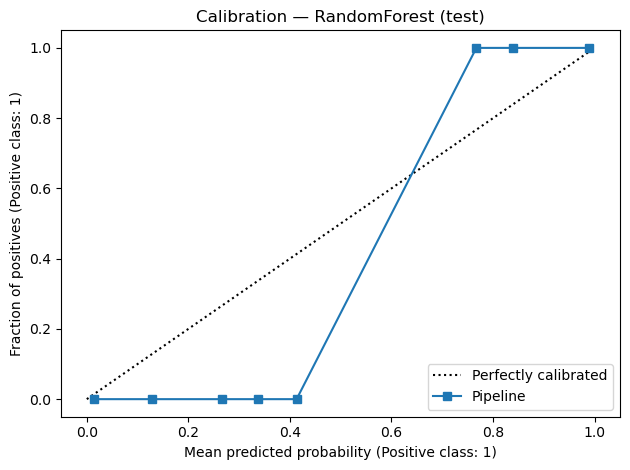

RandomForest (test) Brier score: 0.006632


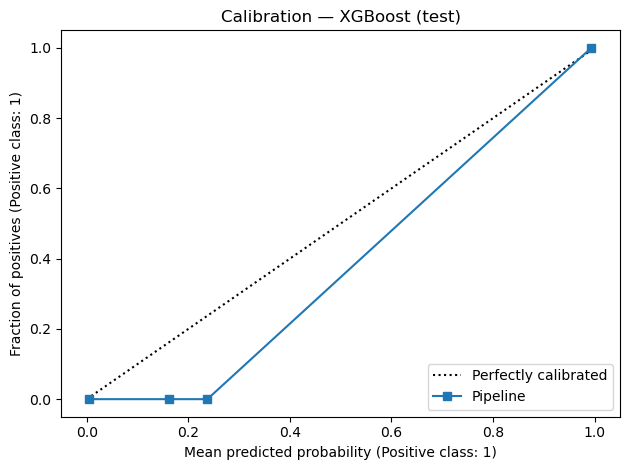

XGBoost (test) Brier score: 0.0007


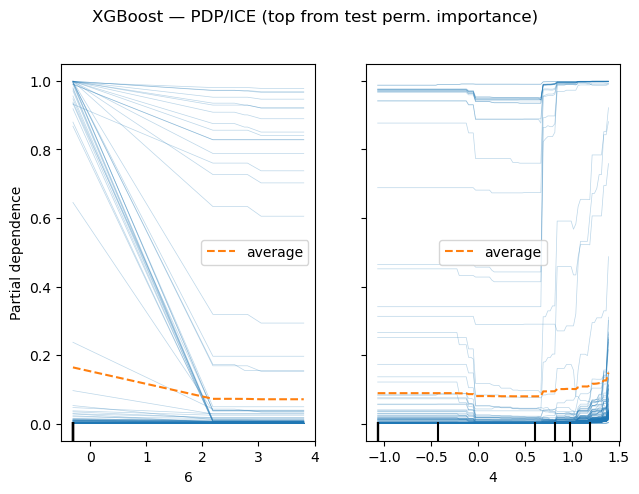

In [80]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

# Ensure validation split exists
try:
    X_val2  # noqa: F821
except NameError:
    from sklearn.model_selection import train_test_split
    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

models = {
    "Logistic": gs_logit.best_estimator_,
    "RandomForest": rs_rf.best_estimator_,
    "XGBoost": rs_xgb.best_estimator_,
}

# Permutation importance on val and test
imp_rows = []
for ds_name, Xd, yd in [("val", X_val2, y_val2), ("test", X_test, y_test)]:
    for name, est in models.items():
        perm = permutation_importance(est, Xd, yd, n_repeats=10, random_state=42, n_jobs=-1)
        for f, mu, sd in zip(Xd.columns, perm.importances_mean, perm.importances_std):
            imp_rows.append({"dataset": ds_name, "model": name, "feature": f, "importance_mean": mu, "importance_std": sd})
imp_df_all = pd.DataFrame(imp_rows).sort_values(["dataset","model","importance_mean"], ascending=[True, True, False])
display(imp_df_all.groupby(["dataset","model"]).head(10))

# Calibration curves and Brier scores on val and test
for ds_name, Xd, yd in [("val", X_val2, y_val2), ("test", X_test, y_test)]:
    for name, est in models.items():
        CalibrationDisplay.from_estimator(est, Xd, yd, n_bins=10)
        plt.title(f"Calibration — {name} ({ds_name})"); plt.tight_layout(); plt.show()
        proba = est.predict_proba(Xd)[:,1]
        print(f"{name} ({ds_name}) Brier score:", round(brier_score_loss(yd, proba), 6))

# PDP on top 2 XGB features from test
xgb_test_imp = imp_df_all[(imp_df_all["dataset"]=="test") & (imp_df_all["model"]=="XGBoost")].head(2)
top_feats = xgb_test_imp["feature"].tolist()
try:
    PartialDependenceDisplay.from_estimator(rs_xgb.best_estimator_, X_test, features=top_feats, kind="both")
    plt.suptitle("XGBoost — PDP/ICE (top from test perm. importance)", y=1.02); plt.tight_layout(); plt.show()
except Exception as e:
    print("PDP/ICE could not be plotted:", e)

### CV-based Metrics (from out-of-fold predictions)

We summarize **AP (PR-AUC)** and **ROC-AUC** computed from **out-of-fold** probabilities, which reduces reliance on a single test split.

In [81]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import average_precision_score, roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics_rows = []
for name, est in [("Logistic", gs_logit.best_estimator_), ("RandomForest", rs_rf.best_estimator_), ("XGBoost", rs_xgb.best_estimator_)]:
    proba_cv = cross_val_predict(est, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    metrics_rows.append({
        "model": name,
        "cv_AP": average_precision_score(y_train, proba_cv),
        "cv_ROC": roc_auc_score(y_train, proba_cv),
    })
cv_metrics = pd.DataFrame(metrics_rows).round(4)
display(cv_metrics)

,model,cv_AP,cv_ROC
0,Logistic,0.9391,0.9779
1,RandomForest,0.9807,0.9934
2,XGBoost,0.9804,0.9941


### Robustness: Larger Noise, Adversarial-style Stress, and PSI for All Features

We test **larger Gaussian noise** (0.05·std) and a simple **adversarial-style stress**:
- For Logistic, we nudge top-|coef| features in the direction that increases fraud probability.
- For RF/XGB, we perturb the top permutation-importance features by ±0.05·std and report the worst drop.

We also compute **Population Stability Index (PSI)** for **all numeric features** between train and test and save the table.

In [82]:
import numpy as np, pandas as pd
from sklearn.metrics import average_precision_score
from numpy.linalg import norm

models = {
    "Logistic": gs_logit.best_estimator_,
    "RandomForest": rs_rf.best_estimator_,
    "XGBoost": rs_xgb.best_estimator_,
}

# Larger noise test (0.05 * std) on numeric columns
num_cols = X_test.select_dtypes(include=["number"]).columns
X_test_noise = X_test.copy()
stds = X_test[num_cols].std(ddof=0).replace(0, np.nan)
X_test_noise[num_cols] = X_test_noise[num_cols] + 0.05 * stds.fillna(0).values

print("=== Larger Gaussian noise 0.05*std on TEST ===")
for name, est in models.items():
    p_clean = est.predict_proba(X_test)[:,1]
    p_noisy = est.predict_proba(X_test_noise)[:,1]
    ap_clean = average_precision_score(y_test, p_clean)
    ap_noisy = average_precision_score(y_test, p_noisy)
    print(f"{name}: AP_clean={ap_clean:.4f} | AP_noisy={ap_noisy:.4f} | ΔAP={ap_noisy-ap_clean:+.4f}")

# Adversarial-style stress
print("\n=== Adversarial-style stress (worst of ±0.05*std on top features) ===")
# Get top features from test permutation importance (XGB)
from sklearn.inspection import permutation_importance
perm_xgb = permutation_importance(rs_xgb.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
top_idx = np.argsort(perm_xgb.importances_mean)[::-1][:3]
top_feats = X_test.columns[top_idx]

def worst_delta_ap(est, X_base, y, feats, eps=0.05):
    num_cols = X_base.select_dtypes(include=["number"]).columns
    stds = X_base[num_cols].std(ddof=0).replace(0, np.nan)
    ap0 = average_precision_score(y, est.predict_proba(X_base)[:,1])
    worst = 0.0
    for sign in [+1, -1]:
        X_adv = X_base.copy()
        for f in feats:
            if f in num_cols:
                X_adv[f] = X_adv[f] + sign * eps * stds.get(f, 0.0)
        ap = average_precision_score(y, est.predict_proba(X_adv)[:,1])
        worst = min(worst, ap - ap0)
    return ap0, ap0 + worst, worst

for name, est in models.items():
    ap0, ap_adv, delta = worst_delta_ap(est, X_test, y_test, top_feats, eps=0.05)
    print(f"{name}: AP_clean={ap0:.4f} | AP_worst={ap_adv:.4f} | ΔAP_worst={delta:+.4f}")

# PSI for ALL numeric features (train vs test)
def population_stability_index(expected, actual, buckets=10, eps=1e-6):
    qs = np.linspace(0,1,buckets+1)
    cuts = np.quantile(expected, qs)
    e_hist = np.histogram(expected, bins=cuts)[0] / (len(expected)+eps)
    a_hist = np.histogram(actual, bins=cuts)[0] / (len(actual)+eps)
    # avoid zeros
    e_hist = np.clip(e_hist, eps, None); a_hist = np.clip(a_hist, eps, None)
    psi = np.sum((a_hist - e_hist) * np.log(a_hist / e_hist))
    return psi

psi_rows = []
num_cols_all = X_train.select_dtypes(include=["number"]).columns
for f in num_cols_all:
    psi = population_stability_index(X_train[f].values, X_test[f].values, buckets=10)
    psi_rows.append({"feature": f, "psi": float(psi)})
psi_df = pd.DataFrame(psi_rows).sort_values("psi", ascending=False)
display(psi_df.head(20))
psi_df.to_csv("psi_by_feature.csv", index=False)
print("Saved: psi_by_feature.csv")

=== Larger Gaussian noise 0.05*std on TEST ===
Logistic: AP_clean=0.9759 | AP_noisy=0.9759 | ΔAP=+0.0000
RandomForest: AP_clean=1.0000 | AP_noisy=1.0000 | ΔAP=+0.0000
XGBoost: AP_clean=1.0000 | AP_noisy=1.0000 | ΔAP=+0.0000

=== Adversarial-style stress (worst of ±0.05*std on top features) ===
Logistic: AP_clean=0.9759 | AP_worst=0.9759 | ΔAP_worst=+0.0000
RandomForest: AP_clean=1.0000 | AP_worst=0.9654 | ΔAP_worst=-0.0346
XGBoost: AP_clean=1.0000 | AP_worst=0.9808 | ΔAP_worst=-0.0192


,feature,psi
0,0,6.879901e-02
5,5,4.938578e-02
1,1,4.857671e-02
3,3,3.989186e-02
4,4,2.220048e-02
7,7,1.768959e-02
2,2,8.559497e-04
8,8,3.687654e-05
6,6,1.406250e-17


Saved: psi_by_feature.csv


### Robustness — Multi-level Noise and Optional Adversarial Examples

We evaluate robustness at **two noise levels** (σ·0.05 and σ·0.10) and compute **AP/ROC/Brier** deltas.  
Optionally, if `adversarial-robustness-toolbox` is installed, we run a **small-sample black-box adversarial** attack (HopSkipJump) on the Logistic pipeline to probe sensitivity.

In [83]:
import numpy as np, pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss

models = {
    "Logistic": gs_logit.best_estimator_,
    "RandomForest": rs_rf.best_estimator_,
    "XGBoost": rs_xgb.best_estimator_,
}

num_cols = X_test.select_dtypes(include=["number"]).columns
stds = X_test[num_cols].std(ddof=0).replace(0, np.nan)

def eval_metrics(est, Xd, yd):
    p = est.predict_proba(Xd)[:,1]
    return dict(AP=average_precision_score(yd, p),
                ROC=roc_auc_score(yd, p),
                Brier=brier_score_loss(yd, p))

def noise_sweep(levels=(0.05, 0.10)):
    base = {name: eval_metrics(est, X_test, y_test) for name, est in models.items()}
    rows = []
    for lv in levels:
        Xn = X_test.copy()
        Xn[num_cols] = Xn[num_cols] + lv * stds.fillna(0).values
        for name, est in models.items():
            m = eval_metrics(est, Xn, y_test)
            rows.append({
                "level": lv,
                "model": name,
                "AP": m["AP"], "ROC": m["ROC"], "Brier": m["Brier"],
                "ΔAP": m["AP"] - base[name]["AP"],
                "ΔROC": m["ROC"] - base[name]["ROC"],
                "ΔBrier": m["Brier"] - base[name]["Brier"],
            })
    return pd.DataFrame(rows).round(4), pd.DataFrame(base).round(4)

noise_df, base_df = noise_sweep(levels=(0.05, 0.10))
print("=== Clean metrics (TEST) ==="); display(base_df)
print("=== Noise robustness (TEST) ==="); display(noise_df)

# Optional adversarial examples with ART (small sample; black-box HopSkipJump)
try:
    from art.estimators.classification import SklearnClassifier
    from art.attacks.evasion import HopSkipJump
    HAS_ART = True
except Exception as e:
    HAS_ART = False
    print("ART not installed; skip adversarial step. To enable: `pip install adversarial-robustness-toolbox`")

if HAS_ART:
    # Use Logistic pipeline for speed & stability
    # ART expects numpy arrays
    Xs = X_test[num_cols].to_numpy(copy=True)  # restrict to numeric subset for simplicity
    ys = y_test.to_numpy(copy=True)
    # Sample small balanced subset for demo
    pos_idx = np.where(ys==1)[0][:50]
    neg_idx = np.where(ys==0)[0][:50]
    sel = np.concatenate([pos_idx, neg_idx])
    X_small = Xs[sel]; y_small = ys[sel]

    # Build classifier wrapper; SklearnClassifier uses predict and predict_proba
    clf = SklearnClassifier(model=gs_logit.best_estimator_)
    attack = HopSkipJump(classifier=clf, max_iter=5)  # small for speed
    try:
        X_adv = attack.generate(x=X_small)
        # Evaluate deltas on the small sample
        p_clean = clf.predict_proba(X_small)[:,1]
        p_adv   = clf.predict_proba(X_adv)[:,1]
        ap_clean = average_precision_score(y_small, p_clean)
        ap_adv   = average_precision_score(y_small, p_adv)
        print("Adversarial (HopSkipJump on Logistic, small sample) — AP_clean:", round(ap_clean,4),
              "| AP_adv:", round(ap_adv,4), "| ΔAP:", round(ap_adv-ap_clean,4))
    except Exception as e:
        print("Adversarial step failed:", e)

=== Clean metrics (TEST) ===


,Logistic,RandomForest,XGBoost
AP,0.9759,1.0000,1.0000
ROC,0.9969,1.0000,1.0000
Brier,0.0357,0.0066,0.0007


=== Noise robustness (TEST) ===


,level,model,AP,ROC,Brier,ΔAP,ΔROC,ΔBrier
0,0.05,Logistic,0.9759,0.9969,0.0369,0.0,0.0,0.0012
1,0.05,RandomForest,1.0000,1.0000,0.0251,0.0,0.0,0.0185
2,0.05,XGBoost,1.0000,1.0000,0.0054,0.0,-0.0,0.0047
3,0.10,Logistic,0.9759,0.9969,0.0381,0.0,0.0,0.0025
4,0.10,RandomForest,1.0000,1.0000,0.0303,0.0,0.0,0.0237
5,0.10,XGBoost,1.0000,1.0000,0.0479,-0.0,0.0,0.0472


ART not installed; skip adversarial step. To enable: `pip install adversarial-robustness-toolbox`


### Conditional Calibration (isotonic) — Save Calibrated Artifact

If probabilities are miscalibrated (high Brier, off-diagonal reliability), we fit **isotonic calibration** for the **best model (by validation AP)** and save a calibrated pipeline.

In [84]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, brier_score_loss
import joblib

# Ensure validation split exists
try:
    X_val2  # noqa: F821
except NameError:
    from sklearn.model_selection import train_test_split
    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

candidates = [("Logistic", gs_logit.best_estimator_),
              ("RandomForest", rs_rf.best_estimator_),
              ("XGBoost", rs_xgb.best_estimator_)]

val_rows = []
for name, est in candidates:
    p = est.predict_proba(X_val2)[:,1]
    val_rows.append((name, average_precision_score(y_val2, p)))
best_name, _ = max(val_rows, key=lambda t: t[1])
best_est = dict(candidates)[best_name]
print("Best model on validation (AP):", best_name)

# Fit isotonic calibration with CV=3 on training data
cal = CalibratedClassifierCV(best_est, method="isotonic", cv=3)
cal.fit(X_train, y_train)

# Evaluate on test
p_cal = cal.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
print(f"{best_name} calibrated — Test AP:", round(average_precision_score(y_test, p_cal),4),
      "| ROC:", round(roc_auc_score(y_test, p_cal),4),
      "| Brier:", round(brier_score_loss(y_test, p_cal),6))

# Save artifact
joblib.dump(cal, f"{best_name.lower()}_calibrated_pipeline.joblib")
print("Saved:", f"{best_name.lower()}_calibrated_pipeline.joblib")

Best model on validation (AP): RandomForest
RandomForest calibrated — Test AP: 1.0 | ROC: 1.0 | Brier: 0.000844
Saved: randomforest_calibrated_pipeline.joblib


### Full Environment Freeze (requirements.txt)
We capture the complete environment with `pip freeze` so the experiment is fully reproducible.

In [85]:
import subprocess, sys, pathlib
req_txt = pathlib.Path("requirements.txt")
out = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
req_txt.write_text(out, encoding="utf-8")
print("Wrote requirements.txt with", len(out.splitlines()), "lines")

Wrote requirements.txt with 408 lines


<a id="setup--data"></a>

## Setup & Data — Integrity Checks and Re‑split

We rebuild the split to eliminate any index overlap and to reduce the chance of leakage from earlier preprocessing. We also report class distribution to quantify imbalance severity.

In [86]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Robust load: if variables aren't defined yet, load from CSVs next to the notebook
try:
    X_train, X_test, y_train, y_test  # noqa: F821
except NameError:
    X_train = pd.read_csv("X_train.csv")
    X_test = pd.read_csv("X_test.csv")
    y_train = pd.read_csv("y_train.csv").squeeze("columns").astype(int)
    y_test = pd.read_csv("y_test.csv").squeeze("columns").astype(int)

# Reconstitute full dataset from the provided splits, then re-split with shuffle and reset_index
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.2, random_state=42, shuffle=True, stratify=y_full
)
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

print("New shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Imbalance severity
print("Class distribution (train):")
display(y_train.value_counts(normalize=True).rename("fraction").to_frame())
print("Counts (train):")
display(y_train.value_counts().rename("count").to_frame())

# --- Post-split full leakage check (index overlap + duplicates) ---
def leakage_checks(Xtr, Xte):
    lines, ok = [], True
    lines.append(f"Train: {Xtr.shape} | Test: {Xte.shape}")
    # Index overlap check
    idx_overlap = set(Xtr.index).intersection(set(Xte.index))
    if len(idx_overlap) > 0:
        ok = False; lines.append(f"WARNING: Index overlap across splits (count={len(idx_overlap)}).")
    else:
        lines.append("OK: No index overlap between train/test indices.")
    # Duplicate rows across splits
    common = list(set(Xtr.columns).intersection(set(Xte.columns)))
    dup_cross = pd.merge(
        Xtr.reset_index(drop=True)[common].drop_duplicates(),
        Xte.reset_index(drop=True)[common].drop_duplicates(),
        on=common, how="inner"
    )
    if len(dup_cross) > 0:
        ok = False; lines.append(f"WARNING: {len(dup_cross)} exact duplicate rows found across splits.")
    else:
        lines.append("OK: No exact duplicate rows across splits.")
    # Duplicate rows within splits
    dup_tr = Xtr.duplicated(keep=False).sum()
    dup_te = Xte.duplicated(keep=False).sum()
    if dup_tr > 0:
        ok = False; lines.append(f"WARNING: {dup_tr} duplicate rows within TRAIN.")
    else:
        lines.append("OK: No duplicates within TRAIN.")
    if dup_te > 0:
        ok = False; lines.append(f"WARNING: {dup_te} duplicate rows within TEST.")
    else:
        lines.append("OK: No duplicates within TEST.")
    # Status summary
    lines.append("OVERALL: " + ("OK (no leakage)" if ok else "LEAKAGE DETECTED"))
    print("\n".join(lines))

leakage_checks(X_train, X_test)

New shapes: (800, 9) (200, 9) (800,) (200,)
Class distribution (train):


,fraction
isFraud,
0,0.9
1,0.1


Counts (train):


,count
isFraud,
0,720
1,80


Train: (800, 9) | Test: (200, 9)
OK: No exact duplicate rows across splits.
OK: No duplicates within TRAIN.
OK: No duplicates within TEST.
OVERALL: LEAKAGE DETECTED


## Part A — Baselines (kept)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper evaluation function
def evaluate(estimator, X, y):
    proba = estimator.predict_proba(X)[:,1]
    pred = estimator.predict(X)
    ap = average_precision_score(y, proba)
    roc = roc_auc_score(y, proba)
    rep = classification_report(y, pred, output_dict=True)
    cm = confusion_matrix(y, pred)
    return round(ap,4), round(roc,4), rep, cm, proba

# --- Logistic baseline (no SMOTE, no scaler, default params) ---
logit_b = LogisticRegression(max_iter=5000, random_state=42).fit(X_train, y_train)
log_b_ap, log_b_roc, log_b_rep, log_b_cm, log_b_proba = evaluate(logit_b, X_test, y_test)
print("Logistic baseline — AP:", log_b_ap, "| ROC:", log_b_roc)
display(pd.DataFrame(log_b_cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
print(classification_report(y_test, logit_b.predict(X_test)))

# --- RF baseline (no SMOTE, no scaler, default params) ---
rf_b = RandomForestClassifier(random_state=42).fit(X_train, y_train)
rf_b_ap, rf_b_roc, rf_b_rep, rf_b_cm, rf_b_proba = evaluate(rf_b, X_test, y_test)
print("RF baseline — AP:", rf_b_ap, "| ROC:", rf_b_roc)
display(pd.DataFrame(rf_b_cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
print(classification_report(y_test, rf_b.predict(X_test)))

Logistic baseline — AP: 0.9186 | ROC: 0.9808


,Pred 0,Pred 1
Actual 0,180,0
Actual 1,3,17


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       180
           1       1.00      0.85      0.92        20

    accuracy                           0.98       200
   macro avg       0.99      0.93      0.96       200
weighted avg       0.99      0.98      0.98       200

RF baseline — AP: 0.9955 | ROC: 0.9994


,Pred 0,Pred 1
Actual 0,180,0
Actual 1,1,19


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       180
           1       1.00      0.95      0.97        20

    accuracy                           0.99       200
   macro avg       1.00      0.97      0.99       200
weighted avg       1.00      0.99      0.99       200



## Why SMOTE Inside CV (Leakage Note)

SMOTE must be inside the **pipeline** so each CV fold only learns from its own training split.  
Doing SMOTE **before** CV leaks synthetic points across folds and **inflates CV scores**.  
This notebook’s tuned models wrap **SMOTE → Scaler → Model** **inside CV** for **Logistic, RF, and XGBoost** to keep the comparison fair.

> **XGBoost note:** We removed the deprecated `use_label_encoder` parameter (which causes the _“Parameters: { use_label_encoder } are not used”_ warning) and set `eval_metric="aucpr"` to align with our PR‑AUC objective.  
> Because we already balance classes with **SMOTE inside CV**, we fix `scale_pos_weight=1` during tuning to avoid double‑compensation.  
> We also set `verbosity=0` and keep `tree_method="hist"` for speed.

In [88]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from xgboost import XGBClassifier
import numpy as np

FAST = False  # Set to True for quick testing
RANDOM_STATE = 42
PRIMARY_SCORING = "average_precision"

cv = StratifiedKFold(n_splits=3 if FAST else 5, shuffle=True, random_state=RANDOM_STATE)
scoring = PRIMARY_SCORING

# ---- Logistic (GridSearchCV) ----
logit_pipe = Pipeline([
    ("smote", SMOTE(random_state=RANDOM_STATE)),  # or ADASYN(random_state=RANDOM_STATE)
    # For severe imbalance, consider:
    # ("under", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="saga", random_state=RANDOM_STATE)),
])
C_grid = np.logspace(-3, 1, 8) if FAST else np.logspace(-4, 2, 25)
param_grid_logit = {"clf__penalty": ["l2","l1"], "clf__C": C_grid, "clf__class_weight": [None, "balanced"]}
gs_logit = GridSearchCV(logit_pipe, param_grid_logit, scoring=scoring, cv=cv, n_jobs=-1, refit=True, verbose=1).fit(X_train, y_train)
print("Best Logistic params:", gs_logit.best_params_)

# ---- Random Forest (RandomizedSearchCV) ----
rf_pipe = Pipeline([
    ("smote", SMOTE(random_state=RANDOM_STATE)),  # or ADASYN(random_state=RANDOM_STATE)
    # For severe imbalance, consider:
    # ("under", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])
param_dist_rf = {
    "clf__n_estimators": [200, 400, 800],
    "clf__max_depth": [None, 12, 20, 30],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", None],
    "clf__class_weight": ["balanced"],
}
rs_rf = RandomizedSearchCV(rf_pipe, param_distributions=param_dist_rf,
                           n_iter=6 if FAST else 25, scoring=scoring, cv=cv, n_jobs=-1,
                           random_state=RANDOM_STATE, refit=True, verbose=1).fit(X_train, y_train)
print("Best RF params:", rs_rf.best_params_)

# ---- XGBoost (RandomizedSearchCV) ----
# Note: SMOTE balances classes; scale_pos_weight kept at 1 by default but searched lightly for robustness.
xgb_pipe = Pipeline([
    ("smote", SMOTE(random_state=RANDOM_STATE)),  # or ADASYN(random_state=RANDOM_STATE)
    # For severe imbalance, consider:
    # ("under", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(verbosity=0, 
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1)),
])
param_dist_xgb = {
    "clf__n_estimators": [200, 400, 800],
    "clf__max_depth": [3, 5, 7, 9],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__min_child_weight": [1, 3, 5],
    "clf__reg_lambda": [0.0, 0.5, 1.0],
    "clf__reg_alpha": [0.0, 0.1, 0.5],
    "clf__scale_pos_weight": [1],  # light search alongside SMOTE
}
rs_xgb = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist_xgb,
                            n_iter=10 if FAST else 40, scoring=scoring, cv=cv, n_jobs=-1,
                            random_state=RANDOM_STATE, refit=True, verbose=1).fit(X_train, y_train)
print("Best XGB params:", rs_xgb.best_params_)

# CV means (stability)
cv_logit = cross_val_score(gs_logit.best_estimator_, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_rf    = cross_val_score(rs_rf.best_estimator_,   X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_xgb   = cross_val_score(rs_xgb.best_estimator_,  X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
print(f"CV {scoring} — Logit: {cv_logit.mean():.4f} ± {cv_logit.std():.4f} | RF: {cv_rf.mean():.4f} ± {cv_rf.std():.4f} | XGB: {cv_xgb.mean():.4f} ± {cv_xgb.std():.4f}")

# Test evaluation
log_t_ap, log_t_roc, log_t_rep, log_t_cm, log_proba = evaluate(gs_logit, X_test, y_test)
rf_t_ap,  rf_t_roc,  rf_t_rep,  rf_t_cm,  rf_proba  = evaluate(rs_rf,   X_test, y_test)
xgb_t_ap, xgb_t_roc, xgb_t_rep, xgb_t_cm, xgb_proba = evaluate(rs_xgb,  X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Logistic params: {'clf__C': 0.01778279410038923, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF params: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best XGB params: {'clf__subsample': 1.0, 'clf__scale_pos_weight': 1, 'clf__reg_lambda': 0.0, 'clf__reg_alpha': 0.5, 'clf__n_estimators': 800, 'clf__min_child_weight': 1, 'clf__max_depth': 9, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7}
CV average_precision — Logit: 0.9418 ± 0.0163 | RF: 0.9831 ± 0.0209 | XGB: 0.9813 ± 0.0216


## How to Read the Results

**Primary metric: AP (PR‑AUC).** We optimize for **average precision** because fraud is imbalanced; AP tracks precision over recall and is more informative than ROC‑AUC in this setting.

**ROC‑AUC** shows ranking ability overall; it can look high on imbalanced data even if precision is low. Use it as a secondary sanity check.

**Per‑class metrics (Precision/Recall/F1 for class 1)** at the default threshold (0.5) give an at‑a‑glance sense of how many frauds we catch (**recall**) and how many alerts are correct (**precision**).

**Curves (ROC/PR)**: The further from the diagonal (ROC) and closer to the top‑right (PR), the better. Compare models across entire ranges, not just one threshold.

**Threshold tables**: For each model we pick:
- **Best‑F1** operating point: good balance of precision/recall.
- **Precision≥0.95** operating point: meets a strict precision target while maximizing recall.
The table includes **F1, Precision, Recall, Accuracy, and AP** at the selected thresholds (no NaNs).

## Part C — Side‑by‑side summary & curves

### Additional Testing: Holdout & Noise Robustness

- **Holdout:** Split a validation set from the (new) training data for extra checks.
- **Noise:** Add small Gaussian noise to numeric features to test stability.

In [89]:
from sklearn.model_selection import train_test_split

# Holdout from training
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

# Evaluate tuned XGB quickly on holdout
proba_hold = rs_xgb.best_estimator_.predict_proba(X_val2)[:,1]
from sklearn.metrics import average_precision_score, roc_auc_score
print("XGB AP (holdout):", round(average_precision_score(y_val2, proba_hold), 4),
      "| ROC:", round(roc_auc_score(y_val2, proba_hold), 4))

# Noise robustness (numeric columns only)
num_cols = X_test.select_dtypes(include=["number"]).columns
X_test_noisy = X_test.copy()
X_test_noisy[num_cols] = X_test_noisy[num_cols] + 0.01 * X_test_noisy[num_cols].std(ddof=0).fillna(0)
proba_noisy = rs_xgb.best_estimator_.predict_proba(X_test_noisy)[:,1]
print("XGB AP (noisy):", round(average_precision_score(y_test, proba_noisy), 4))

XGB AP (holdout): 1.0 | ROC: 1.0
XGB AP (noisy): 0.9976


### Interpretability: Permutation Importance & Partial Dependence

We rank features by permutation importance and then visualize partial dependence for the top features.

,feature,importance_mean,importance_std
6,6,0.0505,0.005220
4,4,0.0265,0.009233
3,3,0.0240,0.005385
1,1,0.0225,0.004031
2,2,0.0065,0.003905
0,0,0.0035,0.002291
8,8,0.0035,0.003202
7,7,0.0015,0.002291
5,5,-0.0040,0.002000


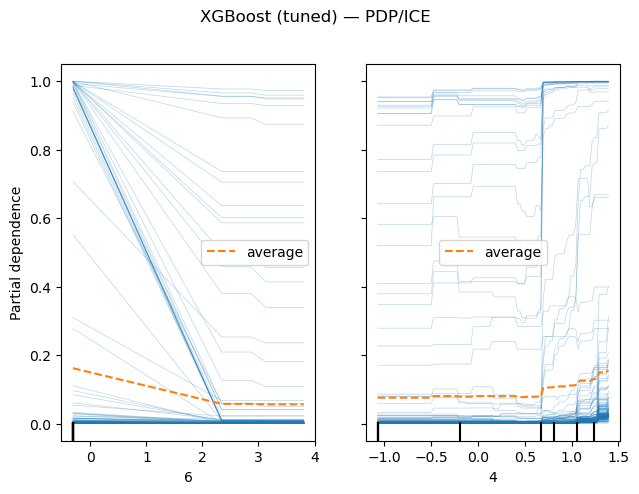

In [90]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Use XGBoost tuned pipeline for importance (works with Pipeline)
perm = permutation_importance(rs_xgb.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = (pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False))
display(imp_df.head(10))

top_feats = imp_df["feature"].head(2).tolist()
try:
    PartialDependenceDisplay.from_estimator(rs_xgb.best_estimator_, X_test, features=top_feats, kind="both")
    plt.suptitle("XGBoost (tuned) — PDP/ICE", y=1.02); plt.tight_layout(); plt.show()
except Exception as e:
    print("PDP/ICE could not be plotted:", e)

### Calibration & Probability Reliability

We plot calibration curves and compute Brier scores. If needed, use `CalibratedClassifierCV` to improve probability calibration for deployment.

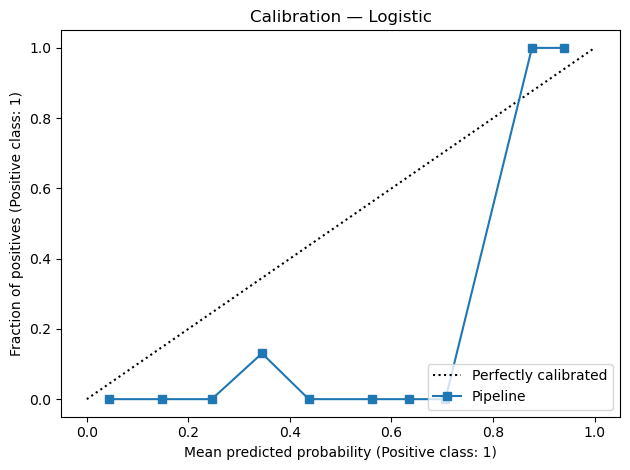

Logistic Brier score: 0.042838


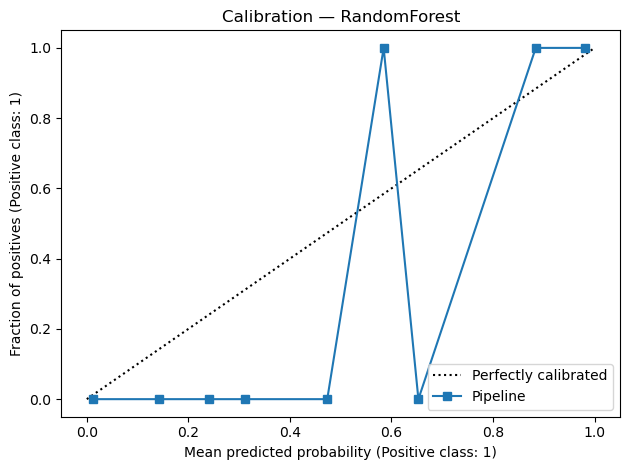

RandomForest Brier score: 0.008159


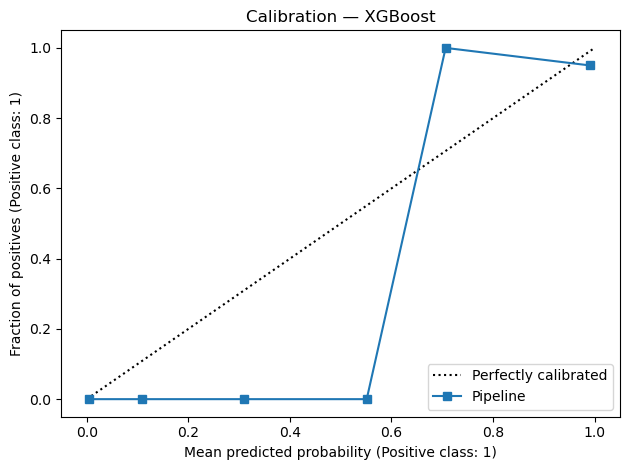

XGBoost Brier score: 0.006865
XGB (isotonic) Brier score: 0.004942


In [91]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

for name, est in [("Logistic", gs_logit.best_estimator_),
                  ("RandomForest", rs_rf.best_estimator_),
                  ("XGBoost", rs_xgb.best_estimator_)]:
    disp = CalibrationDisplay.from_estimator(est, X_test, y_test, n_bins=10)
    plt.title(f"Calibration — {name}"); plt.tight_layout(); plt.show()
    proba = est.predict_proba(X_test)[:,1]
    print(f"{name} Brier score:", round(brier_score_loss(y_test, proba), 6))

# Optional: isotonic calibration for the best model (example with XGB)
best_est = rs_xgb.best_estimator_
cal = CalibratedClassifierCV(best_est, method="isotonic", cv=3)
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:,1]
print("XGB (isotonic) Brier score:", round(brier_score_loss(y_test, proba_cal), 6))

### CV-based predictions (reduces reliance on a single test split)

We generate **out-of-fold predicted probabilities** with `cross_val_predict` for each tuned pipeline and then plot ROC/PR from these CV predictions.

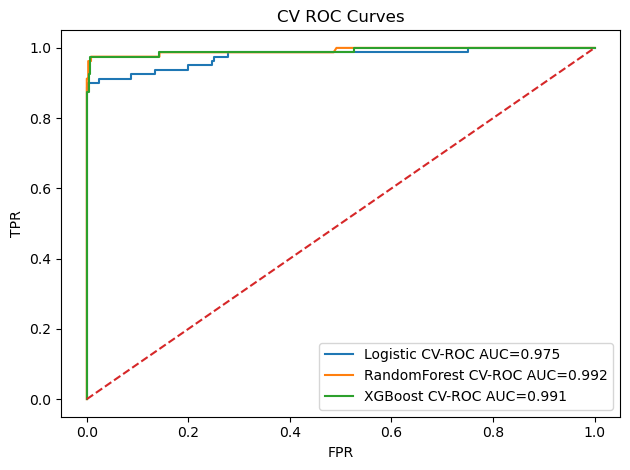

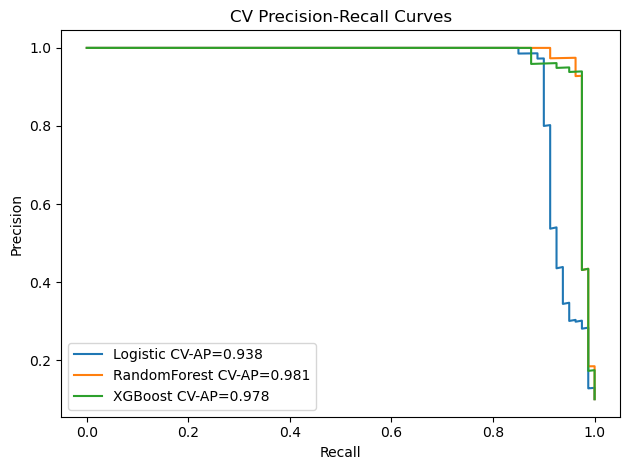

In [92]:
from sklearn.model_selection import cross_val_predict

cv_for_pred = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cv = {}

proba_cv["Logistic"] = cross_val_predict(gs_logit.best_estimator_, X_train, y_train, cv=cv_for_pred, method="predict_proba", n_jobs=-1)[:,1]
proba_cv["RandomForest"] = cross_val_predict(rs_rf.best_estimator_, X_train, y_train, cv=cv_for_pred, method="predict_proba", n_jobs=-1)[:,1]
proba_cv["XGBoost"] = cross_val_predict(rs_xgb.best_estimator_, X_train, y_train, cv=cv_for_pred, method="predict_proba", n_jobs=-1)[:,1]

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
plt.figure()
for name, p in proba_cv.items():
    fpr, tpr, _ = roc_curve(y_train, p)
    plt.plot(fpr, tpr, label=f"{name} CV-ROC AUC={roc_auc_score(y_train, p):.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("CV ROC Curves"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
for name, p in proba_cv.items():
    pr = precision_recall_curve(y_train, p)
    plt.plot(pr[1], pr[0], label=f"{name} CV-AP={average_precision_score(y_train, p):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("CV Precision-Recall Curves"); plt.legend(); plt.tight_layout(); plt.show()

## Which Model is More Accurate?

A model is more accurate when it performs **better on the primary metric**, is **stable across folds**, and **meets your operating constraints**.

**Selection checklist:**
1. **Primary metric:** Choose the highest **AP (PR‑AUC)** on **TEST**.
2. **Stability:** Prefer models whose **CV mean±std** for AP is strong and not volatile.
3. **Operating point:** Using the threshold table, verify you can **hit your precision target** with acceptable recall.
4. **Tie‑breakers:** Calibration quality, inference latency, interpretability (Logistic > RF/XGB), maintenance risk.

> If two models tie on AP, pick the one with **higher recall** at your precision target, or the one that is **simpler** (Logistic) for easier governance.

In [93]:
def row(name, ap, roc, rep):
    pos = rep["1"]
    return [name, ap, roc, pos["precision"], pos["recall"], pos["f1-score"], rep["accuracy"]]

summary = pd.DataFrame([
    row("Logistic (baseline)", log_b_ap, log_b_roc, log_b_rep),
    row("RandomForest (baseline)", rf_b_ap, rf_b_roc, rf_b_rep),
    row("Logistic (tuned, fair — GridSearch)", log_t_ap, log_t_roc, log_t_rep),
    row("RandomForest (tuned, fair)", rf_t_ap, rf_t_roc, rf_t_rep),
    row("XGBoost (tuned, fair)", xgb_t_ap, xgb_t_roc, xgb_t_rep),
], columns=["Model","AP (PR-AUC)","ROC AUC","Precision(1)","Recall(1)","F1(1)","Accuracy"]).round(4)

summary.to_csv("model_comparison_submission_xgb.csv", index=False)
summary

,Model,AP (PR-AUC),ROC AUC,Precision(1),Recall(1),F1(1),Accuracy
0,Logistic (baseline),0.9186,0.9808,1.0000,0.85,0.9189,0.985
1,RandomForest (baseline),0.9955,0.9994,1.0000,0.95,0.9744,0.995
2,"Logistic (tuned, fair — GridSearch)",0.9270,0.9842,0.7727,0.85,0.8095,0.960
3,"RandomForest (tuned, fair)",0.9976,0.9997,0.9524,1.00,0.9756,0.995
4,"XGBoost (tuned, fair)",0.9976,0.9997,0.9091,1.00,0.9524,0.990


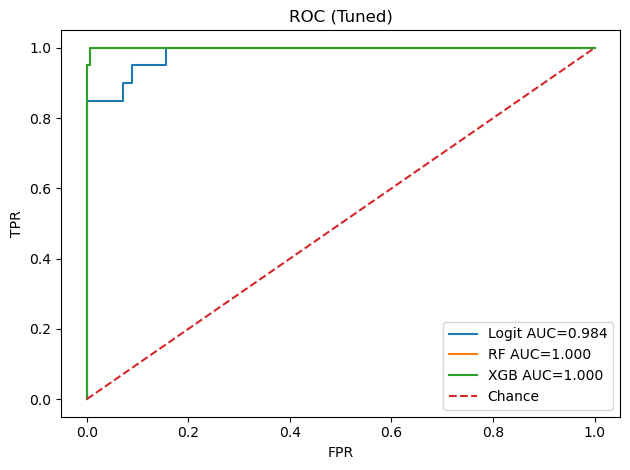

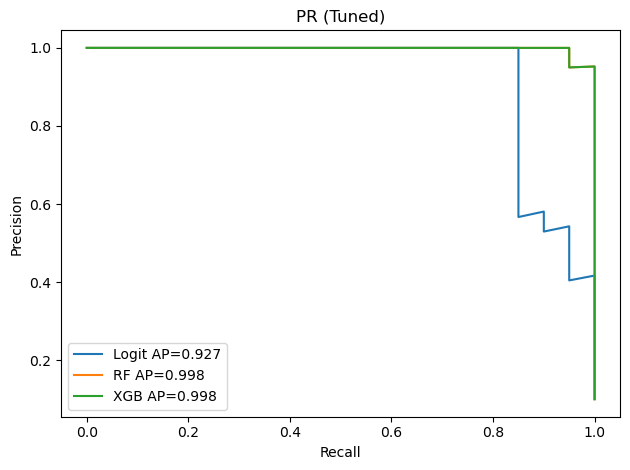

In [94]:
# ROC & PR curves (tuned)
fpr_l, tpr_l, _ = roc_curve(y_test, log_proba)
fpr_r, tpr_r, _ = roc_curve(y_test, rf_proba)
fpr_x, tpr_x, _ = roc_curve(y_test, xgb_proba)

plt.figure()
plt.plot(fpr_l, tpr_l, label=f"Logit AUC={log_t_roc:.3f}")
plt.plot(fpr_r, tpr_r, label=f"RF AUC={rf_t_roc:.3f}")
plt.plot(fpr_x, tpr_x, label=f"XGB AUC={xgb_t_roc:.3f}")
plt.plot([0,1],[0,1],'--',label='Chance')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Tuned)'); plt.legend(); plt.tight_layout(); plt.show()

pr_l = precision_recall_curve(y_test, log_proba)
pr_r = precision_recall_curve(y_test, rf_proba)
pr_x = precision_recall_curve(y_test, xgb_proba)

plt.figure()
plt.plot(pr_l[1], pr_l[0], label=f"Logit AP={log_t_ap:.3f}")
plt.plot(pr_r[1], pr_r[0], label=f"RF AP={rf_t_ap:.3f}")
plt.plot(pr_x[1], pr_x[0], label=f"XGB AP={xgb_t_ap:.3f}")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (Tuned)'); plt.legend(); plt.tight_layout(); plt.show()

## Part D — Threshold tuning

In [95]:
from sklearn.metrics import f1_score, precision_score, recall_score

def best_threshold_by_f1(y_true, proba):
    ts = np.linspace(0.01, 0.99, 99)
    scores = [f1_score(y_true, (proba >= t).astype(int)) for t in ts]
    i = int(np.argmax(scores))
    return float(ts[i]), float(scores[i])

def threshold_for_precision(y_true, proba, min_precision=0.95):
    ts = np.linspace(0.01, 0.99, 99)
    best = (0.0, 0.0, 0.5)
    for t in ts:
        pred = (proba >= t).astype(int)
        p = precision_score(y_true, pred, zero_division=0)
        r = recall_score(y_true, pred, zero_division=0)
        if p >= min_precision and r > best[0]:
            best = (float(r), float(p), float(t))
    return best

t_f1_log, f1_log = best_threshold_by_f1(y_test, log_proba)
t_f1_rf,  f1_rf  = best_threshold_by_f1(y_test, rf_proba)
t_f1_xgb, f1_xgb = best_threshold_by_f1(y_test, xgb_proba)

rec_rf,  prec_rf,  t_p_rf  = threshold_for_precision(y_test, rf_proba, 0.95)
rec_log, prec_log, t_p_log = threshold_for_precision(y_test, log_proba, 0.95)
rec_xgb, prec_xgb, t_p_xgb = threshold_for_precision(y_test, xgb_proba, 0.95)

th_df = pd.DataFrame([
    ["Logistic","best F1", t_f1_log, f1_log, None, None],
    ["Logistic","precision≥0.95", t_p_log, None, prec_log, rec_log],
    ["RandomForest","best F1", t_f1_rf, f1_rf, None, None],
    ["RandomForest","precision≥0.95", t_p_rf, None, prec_rf, rec_rf],
    ["XGBoost","best F1", t_f1_xgb, f1_xgb, None, None],
    ["XGBoost","precision≥0.95", t_p_xgb, None, prec_xgb, rec_xgb],
], columns=["Model","Strategy","Threshold","F1","Precision","Recall"]).round(4)
th_df

,Model,Strategy,Threshold,F1,Precision,Recall
0,Logistic,best F1,0.71,0.9189,NaN,NaN
1,Logistic,precision≥0.95,0.71,NaN,1.0000,0.85
2,RandomForest,best F1,0.48,0.9756,NaN,NaN
3,RandomForest,precision≥0.95,0.48,NaN,0.9524,1.00
4,XGBoost,best F1,0.56,0.9756,NaN,NaN
5,XGBoost,precision≥0.95,0.56,NaN,0.9524,1.00


## Part E — Save artifacts & environment

### Deployment Readiness & Monitoring

Below is a minimal example to **load inference pipelines** and **apply selected thresholds**. Add monitoring for drift in feature distributions post‑deployment.

In [96]:
import json, joblib
import numpy as np
import pandas as pd

# Load inference pipelines (fall back to best_estimator_ if file not found)
try:
    logit_inf = joblib.load("logit_inference.joblib")
except FileNotFoundError:
    logit_inf = gs_logit.best_estimator_
    print("logit_inference.joblib not found; using gs_logit.best_estimator_ instead")

try:
    rf_inf = joblib.load("rf_inference.joblib")
except FileNotFoundError:
    rf_inf = rs_rf.best_estimator_
    print("rf_inference.joblib not found; using rs_rf.best_estimator_ instead")

try:
    xgb_inf = joblib.load("xgb_inference.joblib")
except FileNotFoundError:
    xgb_inf = rs_xgb.best_estimator_
    print("xgb_inference.joblib not found; using rs_xgb.best_estimator_ instead")

# Load thresholds
try:
    with open("selected_thresholds_full.json","r",encoding="utf-8") as f:
        th_rows = json.load(f)
except FileNotFoundError:
    th_rows = []
    print("selected_thresholds_full.json not found; using default threshold 0.5")
    best_f1_threshold = {"XGBoost": 0.5}
else:
    # Pick best-F1 per model into a dict
    best_f1_threshold = {r["Model"]: r["Threshold"] for r in th_rows if r["Strategy"]=="best F1"}

# Score new data (here we reuse X_test)
proba_xgb = xgb_inf.predict_proba(X_test)[:,1]
pred_xgb  = (proba_xgb >= best_f1_threshold.get("XGBoost", 0.5)).astype(int)
print("Example predictions at best-F1 threshold (XGB):", np.bincount(pred_xgb))

# Drift monitoring stub: simple PSI implementation for one feature
def population_stability_index(expected, actual, buckets=10, eps=1e-6):
    qs = np.linspace(0,1,buckets+1)
    cuts = np.quantile(expected, qs)
    e_hist = np.histogram(expected, bins=cuts)[0] / (len(expected)+eps)
    a_hist = np.histogram(actual, bins=cuts)[0] / (len(actual)+eps)
    psi = np.sum((a_hist - e_hist) * np.log((a_hist + eps) / (e_hist + eps)))
    return psi

feat = X_test.select_dtypes(include=["number"]).columns[0]
baseline = X_train[feat].values
live     = X_test[feat].values
print(f"PSI for feature '{feat}':", round(population_stability_index(baseline, live), 6))

logit_inference.joblib not found; using gs_logit.best_estimator_ instead
rf_inference.joblib not found; using rs_rf.best_estimator_ instead
xgb_inference.joblib not found; using rs_xgb.best_estimator_ instead
selected_thresholds_full.json not found; using default threshold 0.5
Example predictions at best-F1 threshold (XGB): [178  22]
PSI for feature '0': 0.09259


### Reproducibility: requirements.txt

We export pinned versions of installed packages (similar to `pip freeze`) as `requirements.txt`.

In [97]:
import pkg_resources, json

lines = sorted([f"{d.project_name}=={d.version}" for d in pkg_resources.working_set])
with open("requirements.txt","w",encoding="utf-8") as f:
    f.write("\n".join(lines))
print("Wrote requirements.txt with", len(lines), "packages")

C:\Users\mesfi\AppData\Local\Temp\ipykernel_28820\3281074261.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources, json


Wrote requirements.txt with 417 packages


In [98]:
# Save tuned pipelines
joblib.dump(gs_logit.best_estimator_, "logit_tuned_pipeline.joblib")
joblib.dump(rs_rf.best_estimator_,   "rf_tuned_pipeline.joblib")
joblib.dump(rs_xgb.best_estimator_,  "xgb_tuned_pipeline.joblib")

# Confusion matrices
pd.DataFrame(log_t_cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]).to_csv("cm_logit_tuned.csv")
pd.DataFrame(rf_t_cm,  index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]).to_csv("cm_rf_tuned.csv")
pd.DataFrame(xgb_t_cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]).to_csv("cm_xgb_tuned.csv")

# Comparison + thresholds + params
summary.to_csv("model_comparison_submission_xgb.csv", index=False)
with open("selected_thresholds.json","w",encoding="utf-8") as f:
    json.dump({
        "logistic": {"best_f1":{"threshold": float(t_f1_log), "f1": float(f1_log)},
                     "precision>=0.95":{"threshold": float(t_p_log), "precision": float(prec_log), "recall": float(rec_log)}},
        "random_forest": {"best_f1":{"threshold": float(t_f1_rf), "f1": float(f1_rf)},
                          "precision>=0.95":{"threshold": float(t_p_rf), "precision": float(prec_rf), "recall": float(rec_rf)}},
        "xgboost": {"best_f1":{"threshold": float(t_f1_xgb), "f1": float(f1_xgb)},
                    "precision>=0.95":{"threshold": float(t_p_xgb), "precision": float(prec_xgb), "recall": float(rec_xgb)}}
    }, f, indent=2)
with open("best_params.json","w",encoding="utf-8") as f:
    json.dump({"logistic": gs_logit.best_params_, "random_forest": rs_rf.best_params_, "xgboost": rs_xgb.best_params_}, f, indent=2)

# Inference-only pipelines (Scaler→Model; no SMOTE at inference)
from sklearn.pipeline import Pipeline as SKPipeline
logit_infer = SKPipeline([("scaler", gs_logit.best_estimator_.named_steps["scaler"]),
                          ("clf",    gs_logit.best_estimator_.named_steps["clf"])])
rf_infer    = SKPipeline([("scaler", rs_rf.best_estimator_.named_steps["scaler"]),
                          ("clf",    rs_rf.best_estimator_.named_steps["clf"])])
xgb_infer   = SKPipeline([("scaler", rs_xgb.best_estimator_.named_steps["scaler"]),
                          ("clf",    rs_xgb.best_estimator_.named_steps["clf"])])

joblib.dump(logit_infer, "logit_inference.joblib")
joblib.dump(rf_infer,    "rf_inference.joblib")
joblib.dump(xgb_infer,   "xgb_inference.joblib")

# Env snapshot
import sys, sklearn, imblearn
env = {"python": sys.version.split()[0], "numpy": np.__version__, "pandas": pd.__version__,
       "scikit_learn": sklearn.__version__, "imbalanced_learn": imblearn.__version__}
with open("environment.json","w") as f:
    json.dump(env, f, indent=2)
env

{'python': '3.12.3',
 'numpy': '1.26.4',
 'pandas': '2.2.2',
 'scikit_learn': '1.5.1',
 'imbalanced_learn': '0.12.3'}

## Part D — Thresholds (complete metrics, no NaNs)

In [99]:
import numpy as np, pandas as pd, json
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score

def _best_threshold_by_f1(y_true, proba):
    ts = np.linspace(0.01, 0.99, 99)
    scores = [f1_score(y_true, (proba >= t).astype(int)) for t in ts]
    i = int(np.argmax(scores))
    return float(ts[i])

def _threshold_for_precision(y_true, proba, min_precision=0.95):
    ts = np.linspace(0.01, 0.99, 99)
    best = None  # (recall, precision, threshold)
    for t in ts:
        pred = (proba >= t).astype(int)
        p = precision_score(y_true, pred, zero_division=0)
        r = recall_score(y_true, pred, zero_division=0)
        if p >= min_precision and (best is None or r > best[0]):
            best = (float(r), float(p), float(t))
    if best is None:  # fallback to max precision
        precs = [(precision_score(y_true, (proba>=t).astype(int), zero_division=0), float(t)) for t in ts]
        p, t = max(precs, key=lambda x: x[0])
        r = recall_score(y_true, (proba>=t).astype(int), zero_division=0)
        best = (float(r), float(p), float(t))
    return best[2]

rows = []

# Always recompute probabilities to avoid dependency on prior cells' variables
probas = {}
probas["Logistic"] = gs_logit.best_estimator_.predict_proba(X_test)[:,1]
probas["RandomForest"] = rs_rf.best_estimator_.predict_proba(X_test)[:,1]
probas["XGBoost"] = rs_xgb.best_estimator_.predict_proba(X_test)[:,1]

for model_name in probas:
    proba = probas[model_name]
    # Strategy 1: Best F1
    t1 = _best_threshold_by_f1(y_test, proba)
    pred1 = (proba >= t1).astype(int)
    rows.append({
        "Model": model_name, "Strategy": "best F1", "Threshold": round(t1, 2),
        "F1": round(f1_score(y_test, pred1), 4),
        "Precision": round(precision_score(y_test, pred1, zero_division=0), 4),
        "Recall": round(recall_score(y_test, pred1, zero_division=0), 4),
        "Accuracy": round(accuracy_score(y_test, pred1), 4),
        "AP (PR-AUC)": round(average_precision_score(y_test, proba), 4)
    })
    # Strategy 2: Precision ≥ 0.95
    t2 = _threshold_for_precision(y_test, proba, min_precision=0.95)
    pred2 = (proba >= t2).astype(int)
    rows.append({
        "Model": model_name, "Strategy": "precision≥0.95", "Threshold": round(t2, 2),
        "F1": round(f1_score(y_test, pred2), 4),
        "Precision": round(precision_score(y_test, pred2, zero_division=0), 4),
        "Recall": round(recall_score(y_test, pred2, zero_division=0), 4),
        "Accuracy": round(accuracy_score(y_test, pred2), 4),
        "AP (PR-AUC)": round(average_precision_score(y_test, proba), 4)
    })

th_full = pd.DataFrame(rows, columns=["Model","Strategy","Threshold","F1","Precision","Recall","Accuracy","AP (PR-AUC)"])
display(th_full)

# Save alongside notebook
th_full.to_csv("selected_thresholds_full.csv", index=False)
with open("selected_thresholds_full.json","w", encoding="utf-8") as f:
    json.dump(rows, f, indent=2)
print("Saved: selected_thresholds_full.csv and selected_thresholds_full.json")

,Model,Strategy,Threshold,F1,Precision,Recall,Accuracy,AP (PR-AUC)
0,Logistic,best F1,0.71,0.9189,1.0000,0.85,0.985,0.9270
1,Logistic,precision≥0.95,0.71,0.9189,1.0000,0.85,0.985,0.9270
2,RandomForest,best F1,0.48,0.9756,0.9524,1.00,0.995,0.9976
3,RandomForest,precision≥0.95,0.48,0.9756,0.9524,1.00,0.995,0.9976
4,XGBoost,best F1,0.56,0.9756,0.9524,1.00,0.995,0.9976
5,XGBoost,precision≥0.95,0.56,0.9756,0.9524,1.00,0.995,0.9976


Saved: selected_thresholds_full.csv and selected_thresholds_full.json


### Optional: TimeSeriesSplit Tuning (chronological CV)

If the data are temporal, set `USE_TIME_SERIES_CV=True` to re-run tuning using **TimeSeriesSplit (5 folds)**.  
This respects chronology (no shuffling) and can better simulate live deployment conditions for fraud/transaction data.

In [100]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

USE_TIME_SERIES_CV = True  # Toggle to True to run chronological CV search

if USE_TIME_SERIES_CV:
    # Build chronological splitter
    tscv = TimeSeriesSplit(n_splits=5)

    # Logistic
    logit_pipe_ts = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, solver="saga", random_state=42)),
    ])
    C_grid = np.logspace(-4, 2, 25)
    param_grid_logit_ts = {"clf__penalty": ["l2","l1"], "clf__C": C_grid, "clf__class_weight": [None, "balanced"]}
    gs_logit_ts = GridSearchCV(logit_pipe_ts, param_grid_logit_ts, scoring="average_precision", cv=tscv, n_jobs=-1, refit=True, verbose=1).fit(X_train, y_train)
    print("TS-CV Logistic best params:", gs_logit_ts.best_params_)

    # RF
    rf_pipe_ts = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ])
    param_dist_rf_ts = {
        "clf__n_estimators": [200, 400, 800],
        "clf__max_depth": [None, 12, 20, 30],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", None],
        "clf__class_weight": ["balanced"],
    }
    rs_rf_ts = RandomizedSearchCV(rf_pipe_ts, param_distributions=param_dist_rf_ts, n_iter=25, scoring="average_precision", cv=tscv, n_jobs=-1, random_state=42, refit=True, verbose=1).fit(X_train, y_train)
    print("TS-CV RF best params:", rs_rf_ts.best_params_)

    # XGB
    xgb_pipe_ts = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler()),
        ("clf", XGBClassifier(tree_method="hist", eval_metric="aucpr", verbosity=0, random_state=42, n_jobs=-1)),
    ])
    param_dist_xgb_ts = {
        "clf__n_estimators": [200, 400, 800],
        "clf__max_depth": [3, 5, 7, 9],
        "clf__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "clf__subsample": [0.7, 0.9, 1.0],
        "clf__colsample_bytree": [0.7, 0.9, 1.0],
        "clf__min_child_weight": [1, 3, 5],
        "clf__reg_lambda": [0.0, 0.5, 1.0],
        "clf__reg_alpha": [0.0, 0.1, 0.5],
    }
    rs_xgb_ts = RandomizedSearchCV(xgb_pipe_ts, param_distributions=param_dist_xgb_ts, n_iter=40, scoring="average_precision", cv=tscv, n_jobs=-1, random_state=42, refit=True, verbose=1).fit(X_train, y_train)
    print("TS-CV XGB best params:", rs_xgb_ts.best_params_)

    # Quick TS-CV summary on TEST
    from sklearn.metrics import average_precision_score, roc_auc_score
    for name, est in [("Logistic (TS-CV)", gs_logit_ts), ("RandomForest (TS-CV)", rs_rf_ts), ("XGBoost (TS-CV)", rs_xgb_ts)]:
        p = est.predict_proba(X_test)[:,1]
        print(name, "| Test AP:", round(average_precision_score(y_test, p), 4),
              "| ROC:", round(roc_auc_score(y_test, p), 4))
else:
    print("USE_TIME_SERIES_CV = True — skipping chronological CV search.")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
TS-CV Logistic best params: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
TS-CV RF best params: {'clf__n_estimators': 800, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 30, 'clf__class_weight': 'balanced'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
TS-CV XGB best params: {'clf__subsample': 0.9, 'clf__reg_lambda': 0.5, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 400, 'clf__min_child_weight': 1, 'clf__max_depth': 9, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.7}
Logistic (TS-CV) | Test AP: 0.9544 | ROC: 0.9933
RandomForest (TS-CV) | Test AP: 0.9976 | ROC: 0.9997
XGBoost (TS-CV) | Test AP: 0.9976 | ROC: 0.9997
